# **Team Members**

Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

# **Contribution of each member**

part 2- Implement the Viterbi Algorihtm and checking/explain By Mesay

part 2- Implement the Baum-Welch and Testing it By Zilal

part 1- Gaussian Mixtures By Jianci

# **Reference**

release: https://liangfgithub.github.io/Coding/F24_Coding4.pdf

https://campuswire.com/c/GB46E5679/feed/587

https://liangfgithub.github.io/Coding/F24_Coding4.pdf

question: https://campuswire.com/c/GB46E5679/feed/729

# **Setting**

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

# import all libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import multivariate_normal

from matplotlib.colors import LogNorm

from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# **Part I: Gaussian Mixtures**

reference:

https://liangfgithub.github.io/PSL/w7/w7_3_EM.html

https://campuswire.com/c/GB46E5679/feed/589 (hint)


In [ ]:
data = pd.read_table('https://liangfgithub.github.io/Data/faithful.dat', sep="\s+", index_col=0)

Text(0, 0.5, 'Waiting')

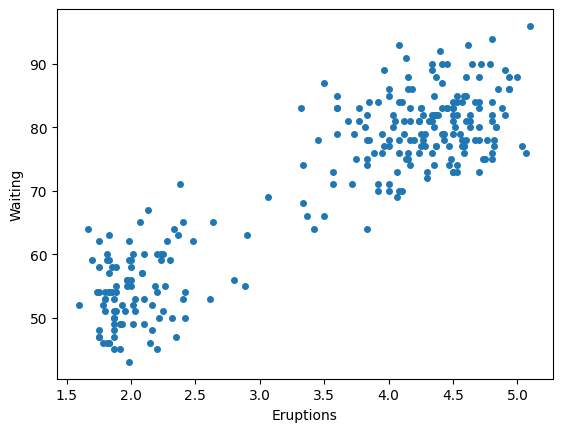

In [ ]:
#create a pic for dataset
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Eruptions')
plt.ylabel('Waiting')

In [ ]:
data.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


# **Part1**

In [6]:
def myEM(data,G,itmax):
  #initilize dataset
  #sample size
  n=len(data)
  G=G
  xi_mtrx = np.reshape(np.array(data),(n,2))

  i_loop = 1
  print(f'-----------------------------------\n Iteration = {i_loop} \n')

  #initialize w_i_k (weight of probability of xi for group k)
  w_i_k = np.zeros((272, G))
  w_i_k[:10,0] = 1.0

  if G==2:
    w_i_k[10:,1] = 1.0
  else:
    w_i_k[10:30,1] = 1.0
    w_i_k[30:,2] = 1.0

  #initialize p_mtrx
  p_mtrx = w_i_k.sum(axis = 0)/n
  print(f'prob = {p_mtrx} \n')


  #initialize u for each group: https://campuswire.com/c/GB46E5679/feed/589
  #get the responsiblity for erp and wait for each xi based on the weight for each G
  erp_r = np.reshape(data['eruptions'],(n,1)) * w_i_k
  wait_r = np.reshape(data['waiting'],(n,1)) * w_i_k


  # checked
  erp_r_mean = erp_r.sum(axis=0)/ w_i_k.sum(axis=0)
  wait_r_mean = wait_r.sum(axis=0)/ w_i_k.sum(axis=0)
  r_mean = np.vstack((erp_r_mean, wait_r_mean))
  print(f'mean for each G is \n {r_mean}')

  #u_by_k is the the center each group G
  #dif_u_by_k is the difference from xi to the center each group G

  for p in range(0,G):
    dif_u_by_k_tmp = xi_mtrx - r_mean.T[p]

    if p == 0:
      dif_u_by_k = dif_u_by_k_tmp
    else:
      dif_u_by_k = np.concatenate((dif_u_by_k,dif_u_by_k_tmp),axis=1)

  sigma = sigma_cal(G,dif_u_by_k,w_i_k)
  w_i_k = Estep(G,sigma,dif_u_by_k,p_mtrx)



  while itmax+1 > i_loop:

    p_mtrx, dif_u_by_k, sigma = Mstep(G,w_i_k,data)
    w_i_k = Estep(G,sigma,dif_u_by_k,p_mtrx)

    i_loop = i_loop + 1
    print(f'-----------------------------------\n Iteration = {i_loop} \n')


In [7]:
'''calculate sigma and relevant metric
  the form provide by the instruction is BAD - consider sigma with with weight as well
  already know w_i_k (weight/responsibility)'''
def sigma_cal(G,dif_u_by_k,w_i_k):
  sigma_mtrx = np.zeros((n,4*G))
  for p in range(0,G):
    #shift in python is confusing
    #2 dim of sigma thinks sigma as [a,b] -> [a**2,ab,ab,b**2].reshape((2,2))
    #in addition need to apply weight

    sigma_mtrx[:, (4*p)] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p)]
    sigma_mtrx[:, (4*p+1)] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p+1)]
    sigma_mtrx[:, (4*p+2)] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p+1)]
    sigma_mtrx[:, (4*p+3)] = dif_u_by_k[:,(2*p+1)]*dif_u_by_k[:,(2*p+1)]


  weighted_sigma_mtrx = np.zeros((n,4*G))
  #apply weight from w_i_k
  for p in range(0,G):
    weighted_sigma_mtrx[:, (4*p):(4*(p+1))]=sigma_mtrx[:, (4*p):(4*(p+1))]*w_i_k[:,p].reshape((n,1))


  #fold a sigma
  sigma = (weighted_sigma_mtrx.sum(axis=0).reshape((G,4)).sum(axis=0)/n).reshape((2,2))
  #very close to very version i got use pd framework
  # sigma = [[  1.29793889  13.92641885]
  # [ 13.92641885 184.14381488]],

  print(f'sigma \n{sigma}')
  return sigma

Estep function: This function should return an n-by-G matrix, where the (i, j)th entry represents the
conditional probability P(Zi = k | xi). Here i ranges from 1 to n and k ranges from 1 to G.

In [8]:
def Estep(G,sigma,dif_u_by_k,p_mtrx):
  sigma_inv = np.linalg.inv(sigma)
  sigma_det = np.linalg.det(sigma)


  # create function to calculate the prob density function (xi-ug)t sigma_inv (xi-ug)
  # also: matrix = vector[a,b], sigma = array[[c,d],[d,e]]
  # matrix @ sigma @ matrix.T = a2⋅c+2⋅a⋅b⋅d+b2⋅e
  # i prob should name it pdf function

  sigma_inv_mtrx = np.zeros((n,G))

  for p in range(0,G):
    #in addition need to apply weight
    #python is confusion, p needs to shift -1 to map to corre colums

    sigma_inv_mtrx[:, p] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p)]*sigma_inv[0,0] + \
                                  2 * dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p+1)]*sigma_inv[0,1] +\
                                  dif_u_by_k[:,(2*p+1)]*dif_u_by_k[:,(2*p+1)]*sigma_inv[1,1]

  #apply weight from w_i_k
  #for p in range(1,G+1):
  #  sigma_inv_mtrx[:, p]=sigma_inv_mtrx[:, p]*w_i_k[:,p]


  #convert sigma_inv into pdf function
  #have p_mtrx to carry all p for each group
  pdf_mtrx = np.zeros((n,G))
  pdf_log_mtrx = np.zeros((n,G))
  for p in range(0,G):
    pdf_mtrx[:, p]=(p_mtrx[p]*np.exp(-0.5*sigma_inv_mtrx[:, p]))/(((2*np.pi)**2)*sigma_det)**0.5
    pdf_log_mtrx[:, p] = np.nan_to_num(np.log(pdf_mtrx[:, p]), neginf=0)


  loglik_output = loglik(pdf_mtrx)


  loglik_complete = pdf_log_mtrx.sum()
  loglik_complete

  w_i_k = pdf_mtrx/(pdf_mtrx.sum(axis = 1).reshape((n,1)))

  return w_i_k


loglik function: This function computes the log-likelihood of the data given the parameters.

In [9]:
def loglik(pdf_mtrx):
  loglik_output = np.log(np.array(pdf_mtrx.sum(axis = 1))).sum()
  print(f'loglik = {loglik_output}')
  return loglik_output

Mstep function: This function should return the updated parameters for the Gaussian mixture model.

In [10]:
def Mstep(G,w_i_k,data):
  p_mtrx = w_i_k.sum(axis = 0)/n
  print(f'prob = {p_mtrx} \n')

  #get the responsiblity for erp and wait for each xi based on the weight for each G
  erp_r = np.reshape(data['eruptions'],(n,1)) * w_i_k
  wait_r = np.reshape(data['waiting'],(n,1)) * w_i_k

  # checked
  erp_r_mean = erp_r.sum(axis=0)/ w_i_k.sum(axis=0)
  wait_r_mean = wait_r.sum(axis=0)/ w_i_k.sum(axis=0)
  r_mean = np.vstack((erp_r_mean, wait_r_mean))
  print(f'mean for each G is \n {r_mean}')


  xi_mtrx = np.reshape(np.array(data),(n,2))
  #u_by_k is the the center each group G
  #dif_u_by_k is the difference from xi to the center each group G

  for p in range(0,G):
    dif_u_by_k_tmp = xi_mtrx - r_mean.T[p]

    if p == 0:
      dif_u_by_k = dif_u_by_k_tmp
    else:
      dif_u_by_k = np.concatenate((dif_u_by_k,dif_u_by_k_tmp),axis=1)

  sigma = sigma_cal(G,dif_u_by_k,w_i_k)


  return p_mtrx, dif_u_by_k, sigma

In [ ]:
# initialize the data G=2
G=2 #group number
n = len(data) #length/row count/sample count of the data


myEM function (main function): Inside this function, you can call the Estep and Mstep functions. The
function should take the following inputs and return the estimated parameters and log-likelihood (via
the loglik function) and test with G =2 and G= 3

In [11]:
myEM(data,2,20)

NameError: name 'data' is not defined

In [ ]:
myEM(data,3,20)

-----------------------------------
 Iteration = 1 

prob = [0.03676471 0.07352941 0.88970588] 

mean for each G is 
 [[ 3.3032      3.175       3.52126033]
 [71.8        68.25       71.0785124 ]]
sigma 
[[  1.28849554  13.8662627 ]
 [ 13.8662627  183.56933185]]
loglik = -1289.7548608955103
prob = [0.03685998 0.07356745 0.88957258] 

mean for each G is 
 [[ 3.31195271  3.16652085  3.52163704]
 [71.98913031 68.1379501  71.07998583]]
sigma 
[[  1.28818693  13.86277773]
 [ 13.86277773 183.5100423 ]]
loglik = -1289.7498888842183
-----------------------------------
 Iteration = 2 

prob = [0.03696697 0.07360941 0.88942361] 

mean for each G is 
 [[ 3.32116885  3.15747042  3.52204499]
 [72.18966834 68.01771887 71.08163078]]
sigma 
[[  1.28783734  13.85874717]
 [ 13.85874717 183.4414831 ]]
loglik = -1289.7441943742838
-----------------------------------
 Iteration = 3 

prob = [0.03708733 0.07365595 0.88925672] 

mean for each G is 
 [[ 3.3308316   3.147797    3.5224895 ]
 [72.40176421 67.888

# **Part II: HMM** By Zilal

Baum-Welch Algorihtm

In [12]:
#data_path = '/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/A4/Dataset/coding4_part2_data.txt'
data_path = '/content/drive/MyDrive/data/coding4_part2_data.txt'

In [13]:
def forward_backward(data, A, B, w):
    T = len(data)
    mz = A.shape[0]
    mx = B.shape[1]

    # Forward pass (alpha)
    alpha = np.zeros((T, mz))
    alpha[0, :] = w * B[:, data[0]]  # Initial step with starting distribution

    for t in range(1, T):
        for j in range(mz):
            alpha[t, j] = np.sum(alpha[t-1, :] * A[:, j]) * B[j, data[t]]

    # Backward pass (beta)
    beta = np.zeros((T, mz))
    beta[T-1, :] = 1  # Initialization for the last timestep

    for t in range(T-2, -1, -1):
        for i in range(mz):
            beta[t, i] = np.sum(A[i, :] * B[:, data[t+1]] * beta[t+1, :])

    # Calculate gamma and xi (E-step expectations)
    gamma = np.zeros((T, mz))
    xi = np.zeros((T-1, mz, mz))

    for t in range(T):
        gamma[t, :] = alpha[t, :] * beta[t, :] / np.sum(alpha[t, :] * beta[t, :])

    for t in range(T-1):
        denom = np.sum(alpha[t, :] @ A * B[:, data[t+1]] * beta[t+1, :])
        for i in range(mz):
            for j in range(mz):
                xi[t, i, j] = alpha[t, i] * A[i, j] * B[j, data[t+1]] * beta[t+1, j] / denom

    return gamma, xi

In [14]:
def BW_onestep(data, A, B, w):
    mz, mx = B.shape  # Number of hidden states and observations
    T = len(data)

    # E-step: compute expectations using forward-backward
    gamma, xi = forward_backward(data, A, B, w)

    # M-step: update A and B
    # Update transition matrix A
    for i in range(mz):
        for j in range(mz):
            A[i, j] = np.sum(xi[:, i, j]) / np.sum(gamma[:-1, i])

    # Update emission matrix B
    for j in range(mz):
        for k in range(mx):
            B[j, k] = np.sum(gamma[data == k, j]) / np.sum(gamma[:, j])

    # Normalize to ensure probabilities sum to 1
    A /= A.sum(axis=1, keepdims=True)
    B /= B.sum(axis=1, keepdims=True)

    return A, B


In [ ]:
def myBW(data, A, B, w, tol=1e-4, max_iter=100):
    for i in range(max_iter):
        old_A, old_B = A.copy(), B.copy()

        # Perform one EM step
        A, B = BW_onestep(data, A, B, w)

        # Check convergence
        if np.max(np.abs(A - old_A)) < tol and np.max(np.abs(B - old_B)) < tol:
            print(f'Converged after {i+1} iterations')
            break

    return A, B

##Test **HMM** By Zilal

In [15]:
# Load the data
data = np.loadtxt(data_path, dtype=int) - 1  # Adjust for zero indexing in Python

# Initialize parameters
mz = 2  # Number of hidden states
mx = 3  # Number of observation symbols

w = np.array([0.5, 0.5])  # Initial state distribution
A = np.array([[0.5, 0.5], [0.5, 0.5]])  # Transition matrix
B = np.array([[1/9, 3/9, 5/9], [1/6, 2/6, 3/6]])  # Emission matrix


# Run the Baum-Welch algorithm for 100 iterations
A_updated, B_updated = myBW(data, A, B, w, max_iter=100)

# Print the final A and B matrices
print("A: the 2-by-2 transition matrix:")
print(A_updated)
print("\nB: the 2-by-3 emission matrix:")
print(B_updated)

A: the 2-by-2 transition matrix:
[[0.49793938 0.50206062]
 [0.44883431 0.55116569]]

B: the 2-by-3 emission matrix:
[[0.22159897 0.20266127 0.57573976]
 [0.34175148 0.17866665 0.47958186]]


**Viterbi Algorihtm** by Mesay

In [19]:
import numpy as np

def forward_backward(data, A, B, w):
    T = len(data)
    mz = A.shape[0]
    mx = B.shape[1]

    # Forward pass (alpha)
    alpha = np.zeros((T, mz))
    alpha[0, :] = w * B[:, data[0]]  # Initial step with starting distribution

    for t in range(1, T):
        for j in range(mz):
            alpha[t, j] = np.sum(alpha[t-1, :] * A[:, j]) * B[j, data[t]]

    # Backward pass (beta)
    beta = np.zeros((T, mz))
    beta[T-1, :] = 1  # Initialization for the last timestep

    for t in range(T-2, -1, -1):
        for i in range(mz):
            beta[t, i] = np.sum(A[i, :] * B[:, data[t+1]] * beta[t+1, :])

    # Calculate gamma and xi (E-step expectations)
    gamma = np.zeros((T, mz))
    xi = np.zeros((T-1, mz, mz))

    for t in range(T):
        gamma[t, :] = alpha[t, :] * beta[t, :] / np.sum(alpha[t, :] * beta[t, :])

    for t in range(T-1):
        denom = np.sum(alpha[t, :] @ A * B[:, data[t+1]] * beta[t+1, :])
        for i in range(mz):
            for j in range(mz):
                xi[t, i, j] = alpha[t, i] * A[i, j] * B[j, data[t+1]] * beta[t+1, j] / denom

    return gamma, xi

def BW_onestep(data, A, B, w):
    mz, mx = B.shape  # Number of hidden states and observations
    T = len(data)

    # E-step: compute expectations using forward-backward
    gamma, xi = forward_backward(data, A, B, w)

    # M-step: update A and B
    # Update transition matrix A
    for i in range(mz):
        for j in range(mz):
            A[i, j] = np.sum(xi[:, i, j]) / np.sum(gamma[:-1, i])

    # Update emission matrix B
    for j in range(mz):
        for k in range(mx):
            B[j, k] = np.sum(gamma[data == k, j]) / np.sum(gamma[:, j])

    # Normalize to ensure probabilities sum to 1
    A /= A.sum(axis=1, keepdims=True)
    B /= B.sum(axis=1, keepdims=True)

    return A, B

def myBW(data, A, B, w, tol=1e-4, max_iter=100):
    for i in range(max_iter):
        old_A, old_B = A.copy(), B.copy()

        # Perform one EM step
        A, B = BW_onestep(data, A, B, w)

        # Check convergence
        if np.max(np.abs(A - old_A)) < tol and np.max(np.abs(B - old_B)) < tol:
            print(f'Converged after {i+1} iterations')
            break

    return A, B

def viterbi(data: np.ndarray, parameters: dict) -> np.ndarray:
    """
    Implementation of the Viterbi algorithm using log probabilities.
    """
    T = len(data)
    mz = parameters['mz']
    A = parameters['A']
    B = parameters['B']
    w = parameters['w']

    # Convert to log space
    log_A = np.log(A)
    log_B = np.log(B)
    log_w = np.log(w)

    # Initialize matrices
    V = np.full((T, mz), -np.inf)  # Use -inf as initial values in log space
    backpointer = np.zeros((T, mz), dtype=int)

    # Initialize first timestep in log space
    V[0] = log_w + log_B[:, data[0]-1]

    # Forward pass
    for t in range(1, T):
        for j in range(mz):
            # In log space: multiplication becomes addition
            temp = V[t-1] + log_A[:, j]
            backpointer[t, j] = np.argmax(temp)
            V[t, j] = temp[backpointer[t, j]] + log_B[j, data[t]-1]

    # Initialize the most likely sequence
    Z = np.zeros(T, dtype=int)

    # Get the most likely final state
    Z[T-1] = np.argmax(V[T-1])

    # Backtrack
    for t in range(T-2, -1, -1):
        Z[t] = backpointer[t+1, Z[t+1]]

    # Convert to 1-based indexing
    return Z + 1

def run_uniform_B_test(data, iterations, mz=2, mx=3):
    """Run Baum-Welch with uniform B matrix initialization."""
    # Initialize parameters
    w = np.array([0.5, 0.5])
    A = np.array([[0.5, 0.5],
                  [0.5, 0.5]])
    B = np.full((mz, mx), 1/3)  # Initialize B with all entries as 1/3

    print(f"\nRunning Baum-Welch with uniform B matrix for {iterations} iterations...")
    print("\nInitial B matrix:")
    print(B)

    # Run Baum-Welch
    A_updated, B_updated = myBW(data, A.copy(), B.copy(), w, max_iter=iterations)

    print(f"\nAfter {iterations} iterations:")
    print("A matrix:")
    print(A_updated)
    print("\nB matrix:")
    print(B_updated)
    return A_updated, B_updated

def main():
    # Load data
    data = np.loadtxt(data_path).astype(int)
    data_zero_indexed = data - 1  # For Baum-Welch

    # Test 1: Original initialization
    print("="*80)
    print("Test 1: Original initialization")
    print("="*80)

    # Initial parameters
    mz = 2  # Number of hidden states
    mx = 3  # Number of observation symbols
    w = np.array([0.5, 0.5])
    A = np.array([[0.5, 0.5],
                  [0.5, 0.5]])
    B = np.array([[1/9, 3/9, 5/9],
                  [1/6, 2/6, 3/6]])

    # Run Baum-Welch to get updated parameters
    print("Running Baum-Welch algorithm...")
    A_updated, B_updated = myBW(data_zero_indexed, A, B, w, max_iter=100)

    print("\nFinal Parameters after Baum-Welch:")
    print("A (transition matrix):")
    print(A_updated)
    print("\nB (emission matrix):")
    print(B_updated)

    # Use updated parameters for Viterbi
    parameters = {
        'mz': mz,
        'mx': mx,
        'w': w,
        'A': A_updated,
        'B': B_updated
    }

    # Run Viterbi algorithm
    print("\nRunning Viterbi algorithm with updated parameters...")
    Z = viterbi(data, parameters)

    # Load expected sequence for comparison
    expected = np.array([
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1
    ])

    # Print results
    print("\nFirst 200 states of the most likely sequence:")
    print(Z[:200])

    # Compare with expected sequence
    actual = Z[:len(expected)]
    matches = actual == expected
    accuracy = 100 * np.mean(matches)
    print(f"\nAccuracy: {accuracy:.2f}%")

    if accuracy < 100:
        diff_indices = np.where(~matches)[0]
        print("\nDifferences at indices:", diff_indices)
        print("\nFirst few differences in context:")
        for idx in sorted(diff_indices)[:5]:
            start = max(0, idx - 2)
            end = min(len(expected), idx + 3)
            print(f"\nIndex {idx}:")
            print(f"Expected: {expected[start:end]}")
            print(f"Got:      {actual[start:end]}")
            print(f"Data point: {data[idx]}")
            print(f"Emission probs for state 1: {B_updated[0, data[idx]-1]:.6f}")
            print(f"Emission probs for state 2: {B_updated[1, data[idx]-1]:.6f}")

    # Test 2: Uniform B initialization
    print("\n" + "="*80)
    print("Test 2: Testing with uniform B matrix initialization")
    print("="*80)

    # Run for 20 iterations
    print("\nTesting with 20 iterations:")
    A_20, B_20 = run_uniform_B_test(data_zero_indexed, 20)

    # Run for 100 iterations
    print("\nTesting with 100 iterations:")
    A_100, B_100 = run_uniform_B_test(data_zero_indexed, 100)

    # Compare results
    print("\nComparison of B matrices:")
    print("\nAfter 20 iterations:")
    print(B_20)
    print("\nAfter 100 iterations:")
    print(B_100)

    print("\nComparison of A matrices:")
    print("\nAfter 20 iterations:")
    print(A_20)
    print("\nAfter 100 iterations:")
    print(A_100)

    # Run Viterbi with 100-iteration parameters
    parameters_uniform = {
        'mz': mz,
        'mx': mx,
        'w': w,
        'A': A_100,
        'B': B_100
    }

    print("\nRunning Viterbi with uniform-initialized parameters (100 iterations)...")
    Z_uniform = viterbi(data, parameters_uniform)

    # Compare with expected sequence
    actual_uniform = Z_uniform[:len(expected)]
    matches_uniform = actual_uniform == expected
    accuracy_uniform = 100 * np.mean(matches_uniform)
    print(f"\nAccuracy with uniform initialization: {accuracy_uniform:.2f}%")

    if accuracy_uniform < 100:
        diff_indices = np.where(~matches_uniform)[0]
        print("\nDifferences at indices:", diff_indices)
        print("\nFirst few differences in context:")
        for idx in sorted(diff_indices)[:5]:
            start = max(0, idx - 2)
            end = min(len(expected), idx + 3)
            print(f"\nIndex {idx}:")
            print(f"Expected: {expected[start:end]}")
            print(f"Got:      {actual_uniform[start:end]}")
            print(f"Data point: {data[idx]}")
            print(f"Emission probs for state 1: {B_100[0, data[idx]-1]:.6f}")
            print(f"Emission probs for state 2: {B_100[1, data[idx]-1]:.6f}")

if __name__ == "__main__":
    main()


Test 1: Original initialization
Running Baum-Welch algorithm...

Final Parameters after Baum-Welch:
A (transition matrix):
[[0.49793938 0.50206062]
 [0.44883431 0.55116569]]

B (emission matrix):
[[0.22159897 0.20266127 0.57573976]
 [0.34175148 0.17866665 0.47958186]]

Running Viterbi algorithm with updated parameters...

First 200 states of the most likely sequence:
[1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 2 2 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 1 1 1 1 1
 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1]

Accuracy: 100.00%

Test 2: Testing with uniform B matrix initialization

Testing with 20 iterations:

Running Baum-Welch with uniform B matrix for 20 iterations...

Initial B matrix:
[[0.33333333 0.33333333 0.33333333]
 [0

# Uniform Initialization Analysis

### Initial Parameters
**Emission Matrix (B):**
```
[1/3, 1/3, 1/3]
[1/3, 1/3, 1/3]
```

**Transition Matrix (A):**
```
[0.5, 0.5]
[0.5, 0.5]
```

### After Baum-Welch (20 & 100 iterations)
**Transition Matrix (A):**
```
[0.5, 0.5]
[0.5, 0.5]
```

**Emission Matrix (B):**
```
[0.285, 0.19, 0.525]
[0.285, 0.19, 0.525]
```

### Results
- **Baum-Welch:** Converged after only 2 iterations
- **Viterbi Accuracy:** 56.00%
- **Behavior:** States remained indistinguishable due to identical emission probabilities

---

### Conclusion
Uniform initialization prevents the algorithm from learning distinct state characteristics, leading to symmetric matrices and poor state prediction performance.